In [2]:
import jax.numpy as jnp
from utils_v2 import KalmanFilter
import math
import matplotlib.pyplot as plt
import jax.random as jrandom
from time import time

In [3]:
sigma_x = 0.01
sigma_t = 0.01
x_values = jnp.arange(0, 1, sigma_x)
t_values = jnp.arange(0, 2, sigma_t)
N = len(x_values)
M = len(t_values)
v = 0.001

In [4]:
N

100

In [5]:
u = jnp.sin(x_values * 2 * math.pi)
f = jnp.cos(x_values * 4 * math.pi)
nu = jnp.zeros(x_values.shape)

In [6]:
x_0 = jnp.expand_dims(jnp.r_[u, f, nu], axis=-1)

In [7]:
X = -2 * jnp.ones(u.shape[0])
X = jnp.diag(X)
X += jnp.diag(jnp.ones(u.shape[0] - 1), k=-1) + jnp.diag(jnp.ones(u.shape[0] - 1), k=1)
X /= sigma_x**2


In [8]:
INVS = jnp.linalg.inv(jnp.eye(X.shape[0]) - 0.5 * sigma_t * v * X)

In [9]:
A_n = INVS @ (jnp.eye(X.shape[0]) + 0.5 * sigma_t * v * X)

In [10]:
B_n = INVS * 0.5 * sigma_t

In [11]:
B_n.shape

(100, 100)

In [12]:
eye = jnp.eye(f.shape[0])
zero = jnp.zeros((f.shape[0], f.shape[0]))
A = jnp.block([[A_n, B_n, zero], [zero, eye, zero], [zero, zero, eye]])

In [13]:
H = jnp.block(
    [
        eye,
        eye,
        eye,
    ]
)
R = jnp.eye(u.shape[0]) * 0.01
Q = jnp.eye(3 * u.shape[0]) * 0.01

P_0 = jnp.ones((3 * u.shape[0], 3 * u.shape[0]))

In [14]:
def plot(kf: KalmanFilter, iterations: int, plot_each: int = None) -> None:
    plot_each = iterations if plot_each is None else plot_each
    plot_each = min(plot_each, iterations)
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(x_values, x_0[N : 2 * N], label="True state")
    ax[1].plot(x_values, x_0[2*N : 3 * N], label="True state")
    for i in range(1, iterations + 1):
        kf.predict(jnp.zeros((u.shape[0], 1)))
        kf.update(x_0)
        kf.x_k = kf.x_k.at[N : 2 * N].set(kf.K[N : 2 * N] @ kf.x_k[:N])
        if i % plot_each == 0:
            ax[0].plot(
                x_values,
                kf.x_k[N : 2 * N],
                label=f"KF estimation after {i} iterations",
            )
            ax[1].plot(
                x_values,
                kf.x_k[2*N : 3 * N],
                label=f"nu KF estimation after {i} iterations",
            )

    plt.xlabel("x_n values", fontsize=15)
    plt.ylabel("f_n values", fontsize=15)
    plt.title("Training evolution", fontsize=15)
    ax[0].legend(fontsize=15)
    ax[1].legend(fontsize=15)
    fig.set_size_inches(17, 20, forward=True)
    plt.show()


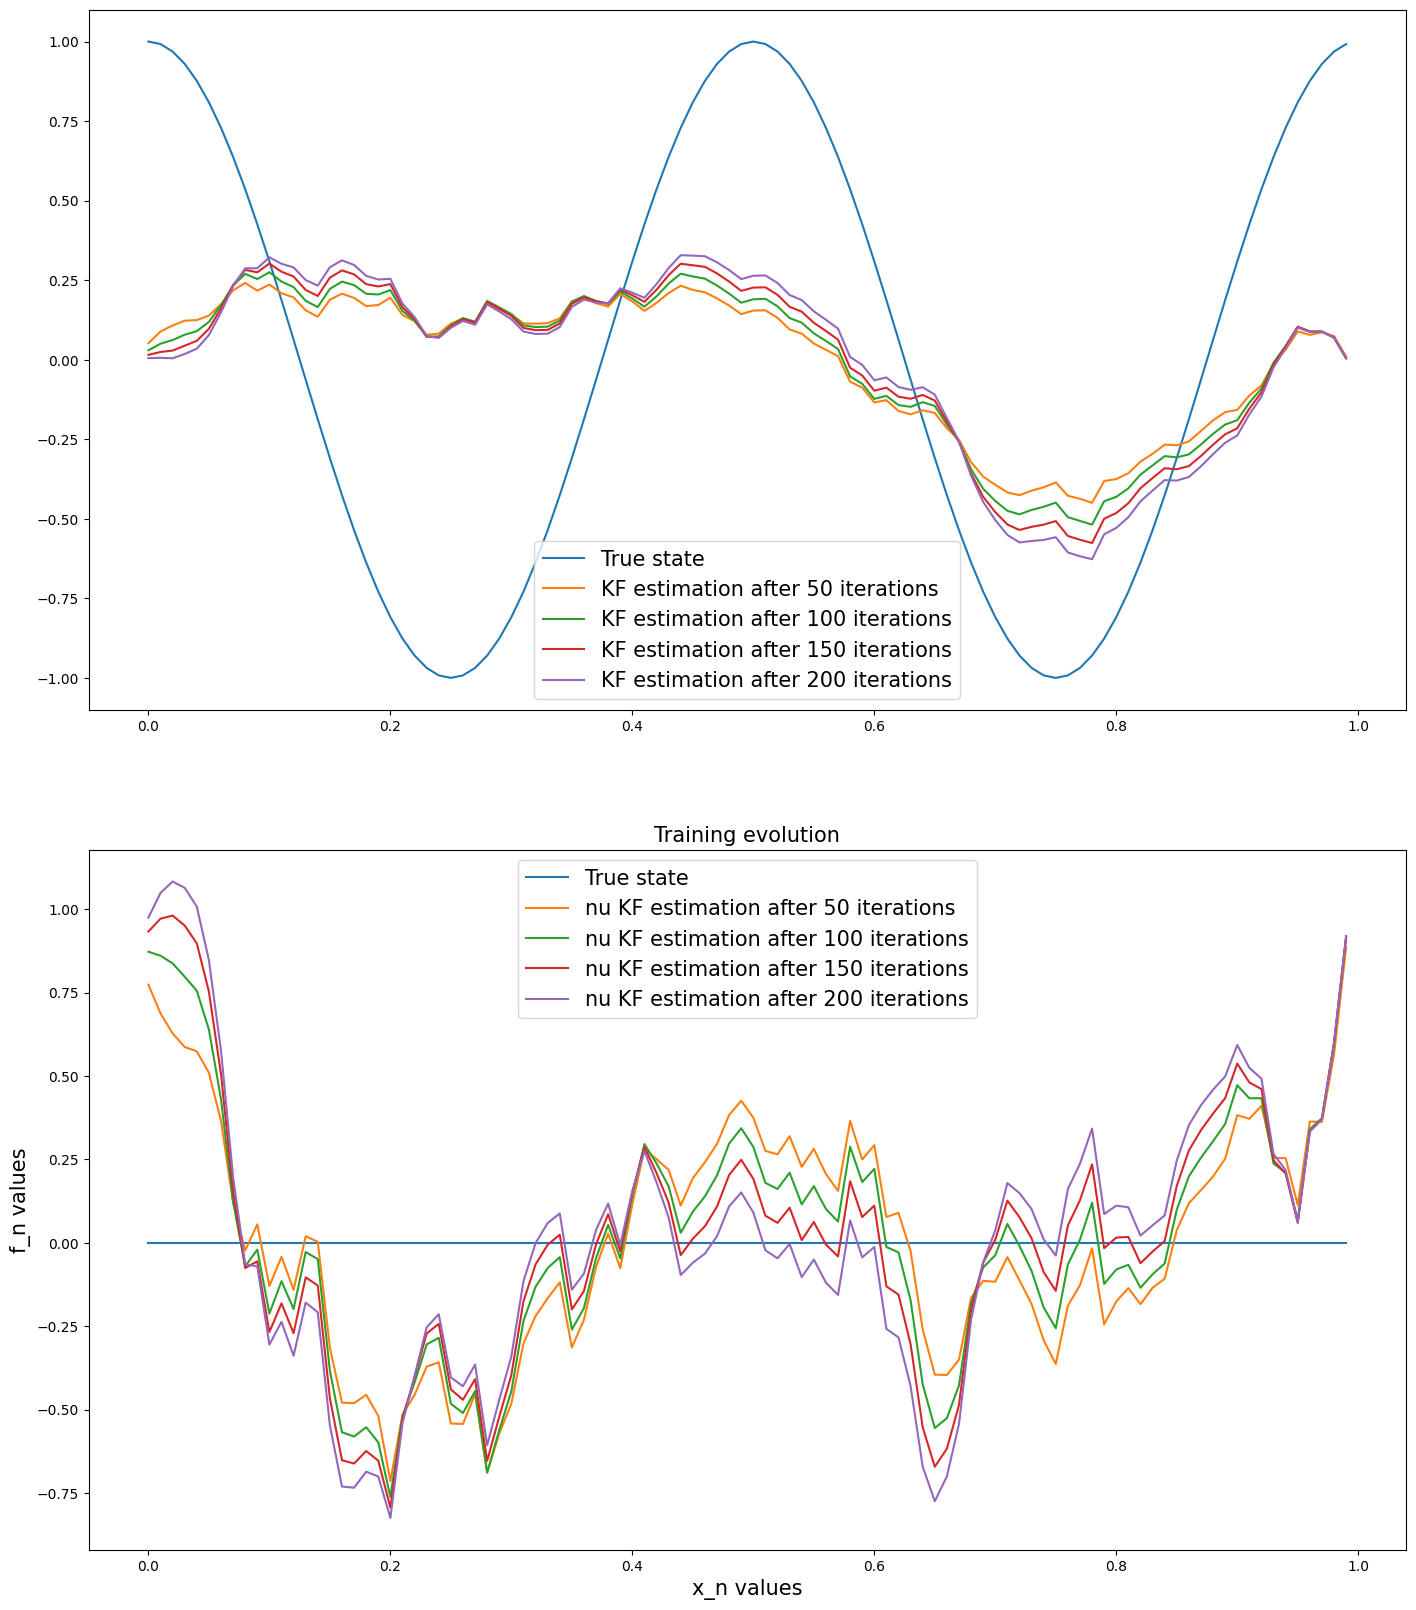

In [15]:
mean = 0
std_dev = 0.01
key = jrandom.PRNGKey(int(time()))
w_k = jrandom.normal(key, shape=(A.shape[0], 1)) * std_dev + mean
key = jrandom.PRNGKey(int(time()))
Z = jrandom.normal(key, shape=(u.shape[0], 1)) * std_dev + mean
kf = KalmanFilter(x_0, A, jnp.zeros((A.shape[0], u.shape[0])), H, H, R, Q, Z, w_k, P_0)

plot(kf, iterations=200, plot_each=50)